# TO DO
* IMAGE SIZE - 512 * 64 (why?)
* try spectogram: chromagram (raw waveforms (not a spect.))
* try transformer

* TRY NORMALISE THE CHROMAGRAM
* SR - TRY TO TAKE SR VALUES FROM THE DATASET


* SIMPLE BASENET
* IMPROVE VAE NET
* LOOK INTO NSCNET ALTERNATIVES
* LOOK INTO METRIC LEARNING AND SIMILARITY RETRIEVAL

# TO ASK THE TUTOR

WHAT THE TUTOR SAID

noise: analyzing the noise in an empirical way--> listening to the songs
alternative: we could fine tune the threshold

normalize out of all the songs

make sure the padding doesn't interfere with other images

# look at the data
analyze duration, understand how big to make the chromagram images

    the images are the same size, but the same amount of of time is different in different signals
    
    let's choose a threshold where to truncate and pad
    
analyze frequencies, are there frequencies we should cut

    is there noise we should cut (we don't think so)
    
do the chromagram

# Utils

* https://analyticsindiamag.com/a-tutorial-on-spectral-feature-extraction-for-audio-analytics/

* https://ridakhan5.medium.com/audio-clustering-with-deep-learning-a7991d605fa5

* https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

* https://www.researchgate.net/publication/333427516_Feature_Learning_for_Bird_Call_Clustering

* https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225

* https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

* https://musicinformationretrieval.com/kmeans.html

* Feature Normalization: https://www.hackaudio.com/digital-signal-processing/amplitude/peak-normalization/#:~:text=Normalizing%20the%20amplitude%20of%20a,magnitude%20equals%20a%20specified%20level.&text=This%20opens%20in%20a%20new%20window.&text=Peak%20amplitude%20is%20a%20measurement%20based%20the%20instantaneous%20level%20of%20a%20signal.

* https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3S1_FeatureNormalization.html

* https://stackoverflow.com/questions/48257311/signal-processing-can-someone-explain-for-me-the-different-type-of-spectrogram

* https://www.geeksforgeeks.org/plotting-a-spectrogram-using-python-and-matplotlib/

* https://it.mathworks.com/matlabcentral/answers/319352-how-do-i-perform-clustering-of-audio-signal

wav files seconds
* https://stackoverflow.com/questions/13039846/what-do-the-bytes-in-a-wav-file-represent

In [1]:
#!pip install librosa
from pathlib import Path
import os
import pandas as pd
import librosa
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, sosfiltfilt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [2]:
#constants
SR = 22050

In [3]:
DIR = './dataset/songs_extracted'

In [4]:
#function that loads the songs from the songs_extracted dataset
def load_songs_extracted(directory):
    data = []
    for bird_names in os.listdir(directory):
        path_bird_names = os.path.join(directory, bird_names)
        if os.path.isdir(path_bird_names):
            for channel in os.listdir(path_bird_names):
                if channel == "CH2":
                    path_channel  = os.path.join(path_bird_names, channel)
                    if os.path.isdir(path_channel):
                        for song in  os.listdir(path_channel):
                            song_num = int(re.search('\d+', song).group())
                            path_song = os.path.join(path_channel, song)
                            signal, sr = librosa.load(path_song)
                            data.append([bird_names, song_num, sr, signal]) #channel is CH2 by default

    # return dataframe creation
    return pd.DataFrame(data, columns=['bird', 'song', 'sr', 'signal'])

In [5]:
df = load_songs_extracted(Path(DIR))
df.head()

KeyboardInterrupt: 

In [ ]:
df.shape

(125, 4)

In [ ]:
print(df['signal'][0].shape)
print(df['signal'][0])

(100479,)
[ 8.5976695e-05  2.9542274e-05  1.9424740e-05 ... -6.7224988e-04
 -8.3629106e-04  1.2994485e-04]


In [ ]:
import IPython.display as ipd
ipd.Audio(df.iloc[0]['signal'], rate=SR)

# Preprocessing

truncation: understand if having signals of different length is a problem

normalization: understand how and if to normalize (-1,1)

### Padding

In [ ]:
def pad_signals(df, policy = "truncation", seconds = 11):

    df['signal_length'] = df['signal'].apply(lambda x: len(x))
    mean = np.mean(df['signal_length'])
    mean = int(mean)
    print('mean:', mean)
    print('standard deviation:', np.std(df['signal_length']))
    print(df[df['signal_length'] < 100000]['signal_length'].count(), 'signals are not truncated out of', df['signal_length'].count())

    if policy == 'padding':
        maxim = np.max(df['signal_length'])
        print(maxim)
        df['padded_signal'] = df['signal'].apply(lambda x: np.pad(x, (0, maxim-len(x))) )

    elif policy == 'truncation':
        #TODO truncation
        trunc_thresh = seconds*22050  #maxim
        #padding
        df['padded_signal'] = df['signal'].apply(lambda x: np.pad(x, (0, trunc_thresh-len(x))) if len(x)<trunc_thresh else x) 
        #truncation
        df['padded_signal'] = df['padded_signal'].apply(lambda x: x[0:trunc_thresh] if len(x)>trunc_thresh else x) 

    print(len(df['padded_signal'][1]))
    return df    

In [ ]:
df = pad_signals(df, policy = "truncation", seconds = 11)

mean: 80078
standard deviation: 33022.80661310398
102 signals are not truncated out of 125
242550


### Amplitude Normalization
if we want to normalize the signals using their own max value for each, we don't need to do it
cause the chromagram ALREADY DOES IT

we can try to normalize all the signals together using the highest value in all the dataset
so the relationships between signal amplitudes is kept

here we are doing the first method

In [ ]:
max_df = df['padded_signal'].apply(lambda x : np.max(np.abs(x))).max()
print(max_df)

0.7834964


In [ ]:
df['normalized_signal'] = df['padded_signal'].apply(lambda x: x/max_df)

#df['normalized_signal'] = df['padded_signal'].apply(lambda x: x/np.max(np.abs(x)))
print(np.max(np.abs(df['normalized_signal'][0])))

0.6588937


### Filtering
We read on nscnet that they removed the noise.
We followed their idea, but are not sure if ch1 (the one they used) is more noisy than ch2 and so we don't need it.

We need to find a way to properly asses the level of noise in the data.

In [ ]:
sr = SR     
order = 5
lf = 1500
filtered = []
def high_pass(sig):
    nyq = sr/2
    sos = butter(order, [lf/nyq], analog=False, btype='highpass', output='sos')
    return sosfiltfilt(sos,sig)

df['filtered_signal'] = df['padded_signal'].apply(lambda x: high_pass(x))    

### Chromagrams

In [ ]:
chromagrams = []
for signal in df['filtered_signal']:
    chrom = librosa.feature.chroma_stft(y=signal, sr=SR)
    chromagrams.append(chrom)
    
#chromagrams = df['normalized_signal'].apply(lambda x: librosa.feature.chroma_stft(y=x, sr=SR))

In [ ]:
#chromagrams

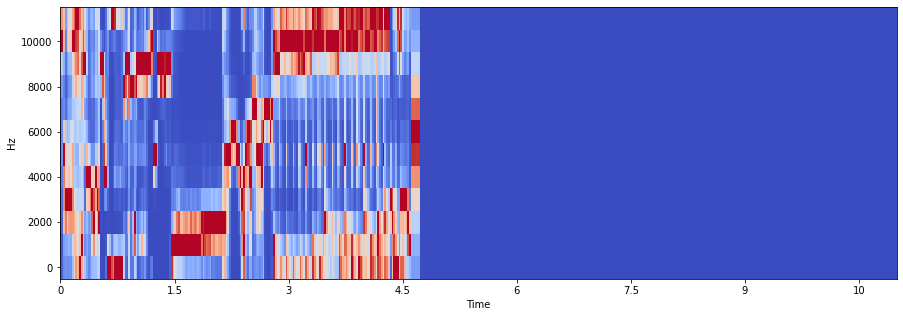

In [ ]:
import librosa.display
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagrams[0], x_axis='time', y_axis='hz', hop_length=512, cmap='coolwarm')

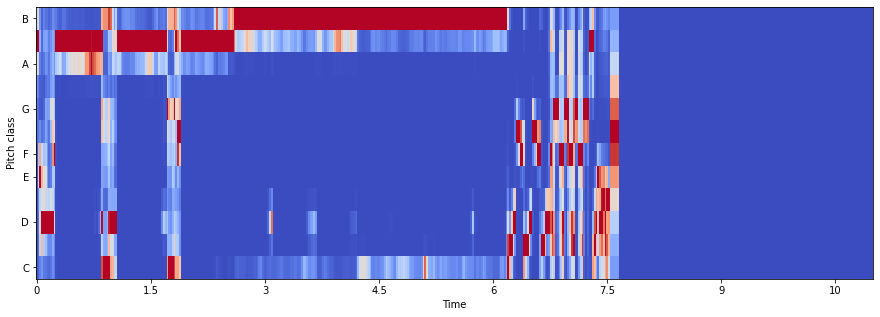

In [ ]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagrams[120], x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

## PCA
n_components: either automatic, or with 12 (because we have 12 pitches)

In [ ]:
chromagrams_array = np.array(chromagrams)
print(chromagrams[0].shape)
print(chromagrams_array.shape)

#x = pca.fit_transform(chromagrams_array)

#pca_chromagrams = chromagrams_array.apply(lambda x: pca.fit_transform(x))

pca_chromagrams = []
for x in chromagrams:
    res = PCA().fit_transform(x)
    res = res.reshape(res.shape[0]*res.shape[1])
    pca_chromagrams.append(res)


(12, 474)
(125, 12, 474)


In [ ]:
#librosa.display.specshow(pca_chromagrams[3], x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

In [ ]:
'''squared_distances = []
for k in range(1,15):
    km = KMeans(n_clusters=k)
    km = km.fit_transform(pca_chromagrams)
    squared_distances.append(km.inertia_)'''

#clusters = KMeans(n_clusters=8, max_iter=10, random_state=0).fit_transform(pca_chromagrams)
#print(clusters)

cluster_number = range(2,120) 

distortions = []
silhouette_scores = []
for n in cluster_number:
    estimator = KMeans(n_clusters = n, init='k-means++', n_init=10, max_iter=300)
    y = estimator.fit_predict(pca_chromagrams)
    distortions.append(estimator.inertia_)
    silhouette_scores.append(silhouette_score(pca_chromagrams,y))

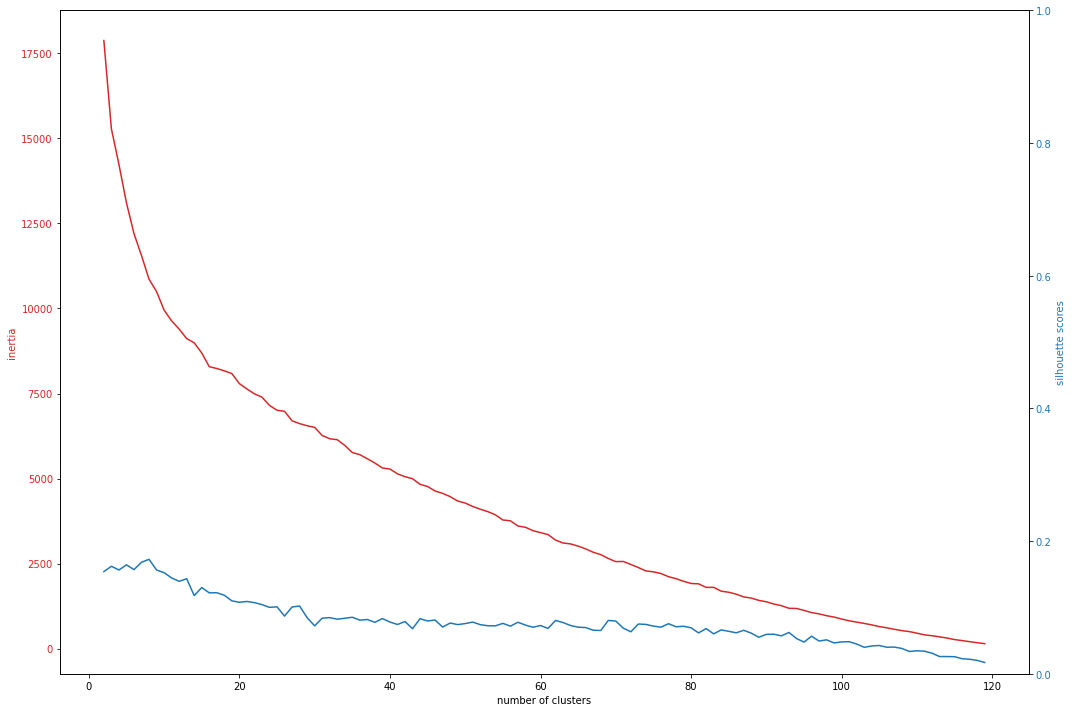

In [ ]:
# Create some mock data
t = cluster_number
data1 = distortions
data2 = silhouette_scores

fig, ax1 = plt.subplots(figsize = (15, 10))
          
color = 'tab:red'
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('inertia', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('silhouette scores', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

there's no elbow O.O

In [ ]:
#librosa.display.specshow(clusters, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

FOR KMEANS CLUSTERING:
compute the predictions:   cluster_predictions = kmeans.fit_predict(x)
find an evaluation method he uses silhouette score

### plot

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def plot_clusters(X, y, dim, points,
                  labels_prefix = 'cluster', 
                  points_name = 'centroids',
                  colors = cm.tab10, # a qualitative map 
                      # https://matplotlib.org/examples/color/colormaps_reference.html
#                   colors = ['brown', 'orange', 'olive', 
#                             'green', 'cyan', 'blue', 
#                             'purple', 'pink'],
#                   points_color = 'red'
                  points_color = cm.tab10(10) # by default the last of the map (to be improved)
                 ):
    """
    Plot a two dimensional projection of an array of labelled points
    X:      array with at least two columns
    y:      vector of labels, length as number of rows in X
    dim:    the two columns to project, inside range of X columns, e.g. (0,1)
    points: additional points to plot as 'stars'
    labels_prefix: prefix to the labels for the legend ['cluster']
    points_name:   legend name for the additional points ['centroids']
    colors: a color map
    points_color: the color for the points
    """
    # plot the labelled (colored) dataset and the points
    labels = np.unique(y)
    for i in range(len(labels)):
        color = colors(i / len(labels)) # choose a color from the map
        plt.scatter(X[y==labels[i],dim[0]], 
                    X[y==labels[i],dim[1]], 
                    s=10, 
                    c = [color], # scatter requires a sequence of colors
                    marker='s', 
                    label=labels_prefix+str(labels[i]))
    plt.scatter(points[:,dim[0]], 
                points[:,dim[1]], 
                s=50, 
                marker='*', 
                c=[points_color], 
                label=points_name)
    plt.legend()
    plt.grid()
    plt.show() 

In [ ]:
X = np.array(pca_chromagrams)
print(X.shape)

(125, 144)


In [ ]:
# to fill
good_k = 15

estimator = KMeans(n_clusters = good_k, init='k-means++', n_init=10, max_iter=300,)
y = estimator.fit_predict(X)

#estimator.cluster_centers_

In [ ]:
#import seaborn as sns
#sns.pairplot(pd.DataFrame(X[:,0:10]))

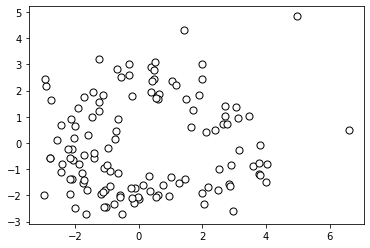

In [ ]:
plt.scatter(X[:,0], X[:,1], c='white', edgecolors='black', marker='o', s=50)

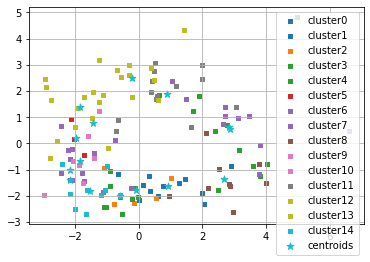

In [ ]:
plot_clusters(X, y, dim= (0,1), points= estimator.cluster_centers_)
              #, ['cluster0', 'cluster1', 'cluster2'], ['centroids'],
             #['blue', 'red', 'pink'], ['cyan'])